## Final Project CS 487
### Model: ResNet18
### Dataset: EuroSAT
### Attacks: Linf DeepFool Attack, HopSkipJump Attack, Binary Search Contrast Reduction, Linf Additive Uniform Noise Attack

In [1]:
!pip install torchvision foolbox eagerpy torchattacks tqdm datasets

INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:0

In [2]:
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.datasets import EuroSAT

# Datasets
from datasets import load_dataset

# Numpy and Standard Libraries
import numpy as np
import random

# Foolbox (for DeepFool, HopSkipJump, UAP)
import foolbox as fb
import eagerpy as ep

# torchattacks (for One-Pixel Attack)
import torchattacks

# Progress bar
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Setup

In [4]:
# Transform dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
# Load dataset
dataset = EuroSAT(root='./data', download=True, transform=transform)

100%|██████████| 94.3M/94.3M [00:00<00:00, 162MB/s]


In [6]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model Setup

In [8]:
# Model Initialization
def get_resnet_model(num_classes=10):
  model = resnet18(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, num_classes)
  return model

model = get_resnet_model()
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model, DataLoaders, Loss, and Optimizer are ready!")

Model, DataLoaders, Loss, and Optimizer are ready!


In [10]:
# Training Loop
epochs = 5
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.3249154548827537
Epoch 2/5, Loss: 0.18705471016510705
Epoch 3/5, Loss: 0.13591960270354558
Epoch 4/5, Loss: 0.1152888458392985
Epoch 5/5, Loss: 0.0996478229496606


In [11]:
# Put the model in eval mode
model.eval()

correct = 0
total = 0

# Turn off gradients during evaluation
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 93.67%


### Attacks

In [12]:
# Put model in eval mode
model.eval()

# Wrap the model for Foolbox
fmodel = fb.PyTorchModel(model, bounds=(0, 1))

# Pick a batch from test_loader
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

attacks = [
    fb.attacks.LinfDeepFoolAttack(),
    fb.attacks.HopSkipJumpAttack(steps=20),
    fb.attacks.BinarySearchContrastReductionAttack(distance=fb.distances.linf),
    fb.attacks.LinfAdditiveUniformNoiseAttack()
]

for attack in attacks:
    print(f"Running {attack.__class__.__name__}...")
    correct = 0
    total = 0

    for i in range(inputs.shape[0]):
        input_i = inputs[i].unsqueeze(0)
        label_i = labels[i].unsqueeze(0)

        try:
            raw_advs, clipped_advs, success = attack(fmodel, input_i, label_i, epsilons=0.01)
            outputs = model(clipped_advs)
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == label_i).float().item()
            total += 1
        except Exception as e:
            print(f"Attack failed on image {i}: {str(e)}")

    if total > 0:
        accuracy = 100 * correct / total
        print(f"Accuracy after {attack.__class__.__name__}: {accuracy:.2f}%\n")
    else:
        print("No successful attacks.\n")

Running LinfDeepFoolAttack...
Accuracy after LinfDeepFoolAttack: 0.00%

Running HopSkipJumpAttack...


/usr/local/lib/python3.11/dist-packages/foolbox/attacks/blended_noise.py:85: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (0 / 1).
  warnings.warn(


Attack failed on image 1: init_attack failed for 1.0 of 1 inputs
Attack failed on image 2: init_attack failed for 1.0 of 1 inputs
Attack failed on image 5: init_attack failed for 1.0 of 1 inputs
Attack failed on image 9: init_attack failed for 1.0 of 1 inputs
Attack failed on image 18: init_attack failed for 1.0 of 1 inputs
Attack failed on image 46: init_attack failed for 1.0 of 1 inputs
Attack failed on image 50: init_attack failed for 1.0 of 1 inputs
Accuracy after HopSkipJumpAttack: 92.98%

Running BinarySearchContrastReductionAttack...
Accuracy after BinarySearchContrastReductionAttack: 93.75%

Running LinfAdditiveUniformNoiseAttack...
Accuracy after LinfAdditiveUniformNoiseAttack: 93.75%



In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def show_adversarial_examples(clean_images, adv_images, labels, preds_clean, preds_adv, class_names, num_images=5):
    clean_images = clean_images.detach().cpu().numpy()
    adv_images = adv_images.detach().cpu().numpy()

    fig, axes = plt.subplots(num_images, 2, figsize=(8, 2 * num_images))
    fig.suptitle("Clean vs Adversarial Examples", fontsize=16)

    for i in range(num_images):
        # Clean Image
        ax = axes[i, 0]
        img = np.transpose(clean_images[i], (1, 2, 0))
        ax.imshow(img)
        ax.set_title(f"Clean: {class_names[preds_clean[i]]}")
        ax.axis("off")

        # Adversarial Image
        ax = axes[i, 1]
        adv_img = np.transpose(adv_images[i], (1, 2, 0))
        ax.imshow(adv_img)
        ax.set_title(f"Adv: {class_names[preds_adv[i]]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

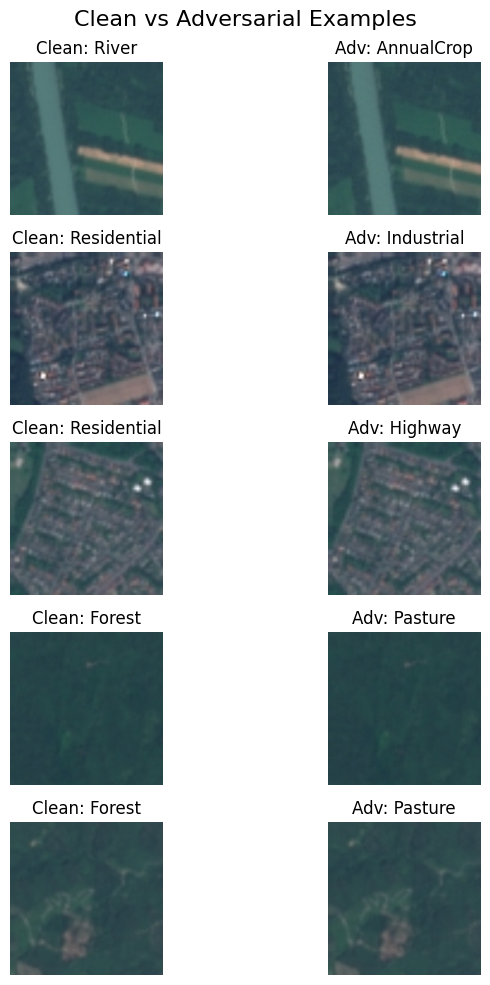

In [15]:
# Get a batch
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Run attack
attack = fb.attacks.LinfDeepFoolAttack()
raw_adv, clipped_adv, success = attack(fmodel, inputs, labels, epsilons=0.01)

# Predictions
with torch.no_grad():
    preds_clean = model(inputs).argmax(dim=1).cpu().numpy()
    preds_adv = model(clipped_adv).argmax(dim=1).cpu().numpy()

# Map indices to class names
class_names = dataset.classes

# Show 5 examples
show_adversarial_examples(inputs, clipped_adv, labels, preds_clean, preds_adv, class_names, num_images=5)


/usr/local/lib/python3.11/dist-packages/foolbox/attacks/blended_noise.py:85: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (57 / 64).
  warnings.warn(


Attack failed on image 63: init_attack failed for 7.0 of 64 inputs


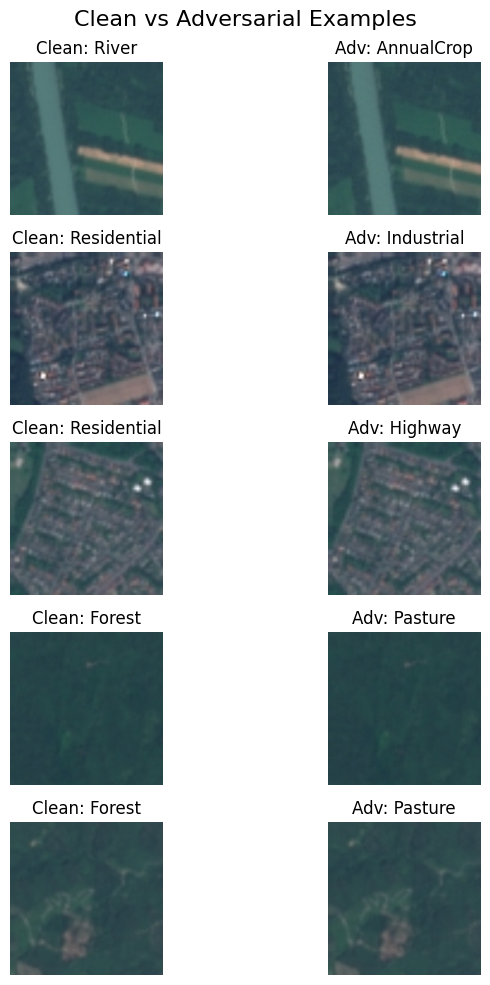

In [18]:
# Get a batch
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Run attack
attack = fb.attacks.HopSkipJumpAttack(steps=20)
try:
  raw_adv, clipped_adv, success = attack(fmodel, inputs, labels, epsilons=0.01)
except Exception as e:
            print(f"Attack failed on image {i}: {str(e)}")

# Predictions
with torch.no_grad():
    preds_clean = model(inputs).argmax(dim=1).cpu().numpy()
    preds_adv = model(clipped_adv).argmax(dim=1).cpu().numpy()

# Map indices to class names
class_names = dataset.classes

# Show 5 examples
show_adversarial_examples(inputs, clipped_adv, labels, preds_clean, preds_adv, class_names, num_images=5)

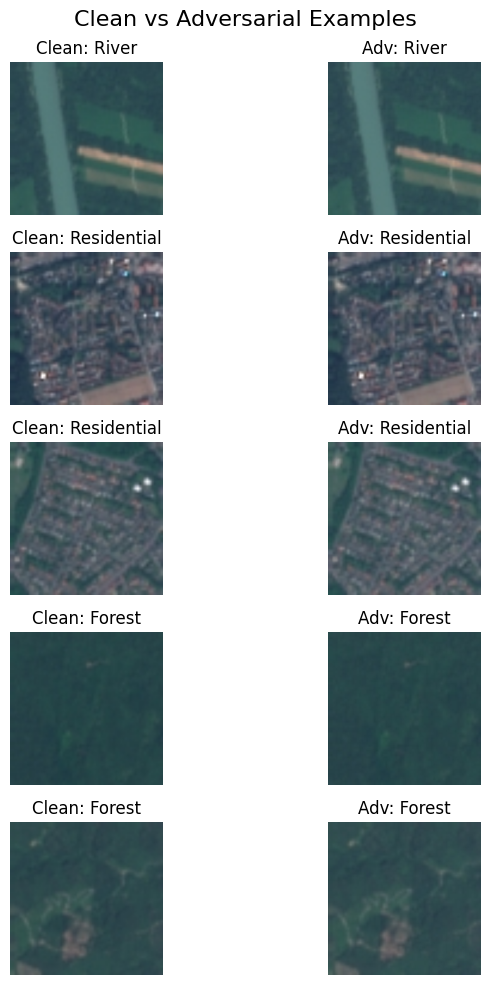

In [19]:
# Get a batch
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Run attack
attack = fb.attacks.BinarySearchContrastReductionAttack(distance=fb.distances.linf)
raw_adv, clipped_adv, success = attack(fmodel, inputs, labels, epsilons=0.01)

# Predictions
with torch.no_grad():
    preds_clean = model(inputs).argmax(dim=1).cpu().numpy()
    preds_adv = model(clipped_adv).argmax(dim=1).cpu().numpy()

# Map indices to class names
class_names = dataset.classes

# Show 5 examples
show_adversarial_examples(inputs, clipped_adv, labels, preds_clean, preds_adv, class_names, num_images=5)

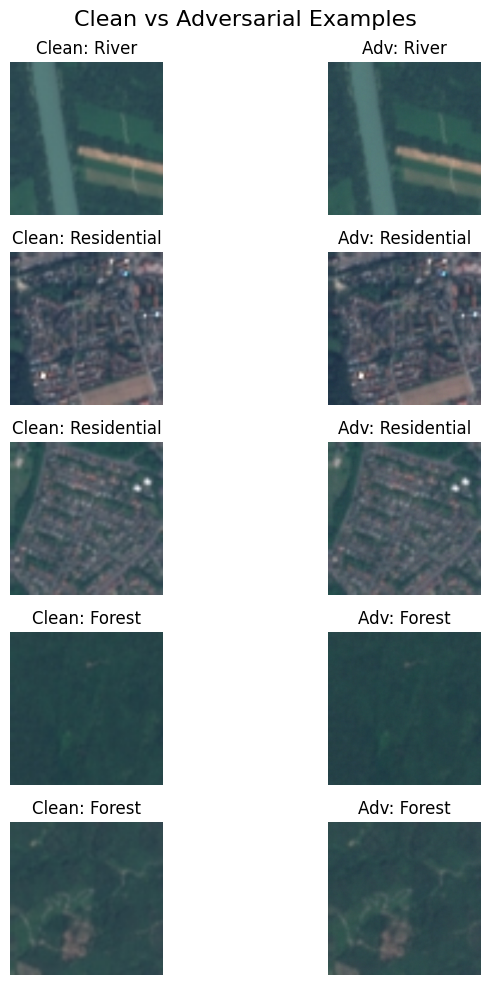

In [20]:
# Get a batch
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Run attack
attack = fb.attacks.LinfAdditiveUniformNoiseAttack()
raw_adv, clipped_adv, success = attack(fmodel, inputs, labels, epsilons=0.01)

# Predictions
with torch.no_grad():
    preds_clean = model(inputs).argmax(dim=1).cpu().numpy()
    preds_adv = model(clipped_adv).argmax(dim=1).cpu().numpy()

# Map indices to class names
class_names = dataset.classes

# Show 5 examples
show_adversarial_examples(inputs, clipped_adv, labels, preds_clean, preds_adv, class_names, num_images=5)

## Model & Attacks Report

### Model Accuracy

The base accuracy of the model was 93.67%. After the Linf DeepFool Attack the accuracy was 0%. After the HopSkipJump Attack the accuracy was 92.98%. After the Binary Search Contrast Reduction Attack the accuracy was 93.75%. After the Linf Additive Uniform Noise Attack the accuracy was 93.75%.

### Linf Deepfool Attack Analysis

The Linf DeepFool Attack is a white-box attack that uses iterative small steps along the decision boundary. It is highly effective against image classifiers and as a result the model had a 0% accuracy after the attack was implemented.

### HopSkipJump Attack Analysis

The HopSkipJump attack is a black-box attack that needs many queries to estimate gradients by binary search. As seen in the results it also will give up/fail if an initial adversarial example can't be found. This attack works better on less accurate or less confident models and as a result had little to no effect on the model.

### Binary Search Contrast Reduction Attack Analysis

I was initially going to do the One-Pixel Attack, but was having issues getting the version in foolbox to work. It kept failing as a result of not having a "distance" value, but when plugging one in as I did with the Binary Search Contrast Reduction Attack it would fail as well due to "not taking distance as an input". Due to the contradictory errors, I switched the attack to the Binary Search Contrast Reduction attack as it is similar, but actually runs.

The Binary Search Contrast Reduction Attack is a black-box attack that is a simple, perceptual-style attack. It works by reducing the contrast to try and fool the model and is not gradient based. As a result it fails on well-trained, high-confidence models and as such had no affact on the model.

### Linf Additive Uniform Noise Attack Analysis

The Linf Additive Uniform Noise Attack randomly adds noise uniformly to the input. There is no gradient use or optimization and is totally untargetted. As such it had pratically no effect on the model due to its robustness.

### Conclusion

When seeing the results of the model after the attacks I thought it best to show the effects of the attacks on the images, however the results of the DeepFool Attack, which is the only one that showed any affect on the model, where in imperceptable. Overall the last three attacks don't seem all that effective, and I while I can see how the HopSkipJump attack could be more effective on a model like the one we did for classifying paintings, I don't see the last two ever having a strong effect on a model. The Binary Search Contrast Reduction Attack may also have had such a small effect due to the nature of the images. As you can see in the examples there is not a lot of contrast to reduce, so it may have had a stronger effectiveness on the models that catergorize signs or the painting model.